# Sampling

Run sampling for a single angle.

In [1]:
import os, sys
import logging
import json
import glob
import importlib
import math

import torch

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
#############

SRC_DIR = os.path.join(
    os.path.dirname(os.getcwd()), "protdiff"
)
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import beta_schedules
import datasets
import plotting
import sampling
import modelling
import utils

BIN_DIR = os.path.join(
    os.path.dirname(os.getcwd()), "bin"
)
assert os.path.isdir(BIN_DIR)
sys.path.append(BIN_DIR)
import sample as sample_bin
import train as train_bin

logging.basicConfig(level=logging.INFO)

In [2]:
# Load in the model
# Omega
ft_idx = 1
MODEL_DIR = "/home/t-kevinwu/projects/protein_diffusion/models_overfitted/overfit_omega_mlp_decoder"

# ft_idx = 2
# MODEL_DIR = "/home/t-kevinwu/projects/protein_diffusion/models_overfitted/overfit_theta_mlp_decoder"

# ft_idx = 3
# MODEL_DIR = "/home/t-kevinwu/projects/protein_diffusion/models_overfitted/overfit_phi_mlp_decoder"

assert os.path.isdir(MODEL_DIR)

In [3]:
with open(os.path.join(MODEL_DIR, "training_args.json")) as source:
    training_args = json.load(source)
training_args

{'results_dir': 'overfit_omega_mlp_decoder',
 'shift_angles_zero_twopi': False,
 'noise_prior': 'gaussian',
 'timesteps': 250,
 'variance_schedule': 'linear',
 'variance_scale': 1.0,
 'implementation': 'huggingface_encoder',
 'time_encoding': 'gaussian_fourier',
 'num_hidden_layers': 12,
 'hidden_size': 384,
 'intermediate_size': 768,
 'num_heads': 12,
 'position_embedding_type': 'absolute',
 'dropout_p': 0.1,
 'decoder': 'mlp',
 'gradient_clip': 1.0,
 'lr': 5e-05,
 'loss': 'radian_l1_smooth',
 'l2_norm': 0.0,
 'l1_norm': 0.0,
 'circle_reg': 0.0,
 'min_epochs': 1000,
 'max_epochs': 10000,
 'early_stop_patience': 0,
 'lr_scheduler': '',
 'use_swa': False,
 'subset': 500,
 'exhaustive_validation_t': False,
 'syn_noiser': '',
 'single_dist_debug': False,
 'single_angle_debug': 1,
 'single_timestep_debug': False,
 'cpu_only': False,
 'batch_size': 128,
 'multithread': True}

In [4]:
beta_values = beta_schedules.get_variance_schedule(
    training_args['variance_schedule'],
    training_args['timesteps'],
)
alpha_beta_values = beta_schedules.compute_alphas(beta_values)
alpha_beta_values.keys()

INFO:root:Getting linear variance schedule with 250 timesteps


dict_keys(['betas', 'alphas', 'alphas_cumprod', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'posterior_variance'])

In [5]:
# Load in the dataset
train_dset, valid_dset, test_dset = train_bin.get_train_valid_test_sets(
    timesteps=training_args['timesteps'],
    variance_schedule=training_args['variance_schedule'],
    noise_prior=training_args['noise_prior'],
    shift_to_zero_twopi=training_args['shift_angles_zero_twopi'],
    var_scale=training_args['variance_scale'],
    toy=training_args['subset'],
    syn_noiser=training_args['syn_noiser'],
    exhaustive_t=training_args['exhaustive_validation_t'],
    single_dist_debug=training_args['single_dist_debug'],
    single_angle_debug=training_args['single_angle_debug'],
    single_time_debug=training_args['single_timestep_debug'],
)
len(train_dset)

INFO:root:Split train contains 372/501 examples
INFO:root:Removed structures with nan 372 -> 304
INFO:root:Length of angles: 39-499, mean 206.86184210526315
INFO:root:Split validation contains 35/501 examples
INFO:root:Removed structures with nan 35 -> 26
INFO:root:Length of angles: 44-308, mean 157.80769230769232
INFO:root:Split test contains 34/501 examples
INFO:root:Removed structures with nan 34 -> 28
INFO:root:Length of angles: 55-227, mean 121.25
INFO:root:Using functools.partial(<class 'datasets.SingleNoisedAngleDataset'>, ft_idx=1) for noise
INFO:root:Getting linear variance schedule with 250 timesteps
INFO:root:Getting linear variance schedule with 250 timesteps
INFO:root:Getting linear variance schedule with 250 timesteps
INFO:root:train: SingleNoisedAngleDataset returning feature 1 with fixed noise None
INFO:root:val: SingleNoisedAngleDataset returning feature 1 with fixed noise None
INFO:root:test: SingleNoisedAngleDataset returning feature 1 with fixed noise None


304

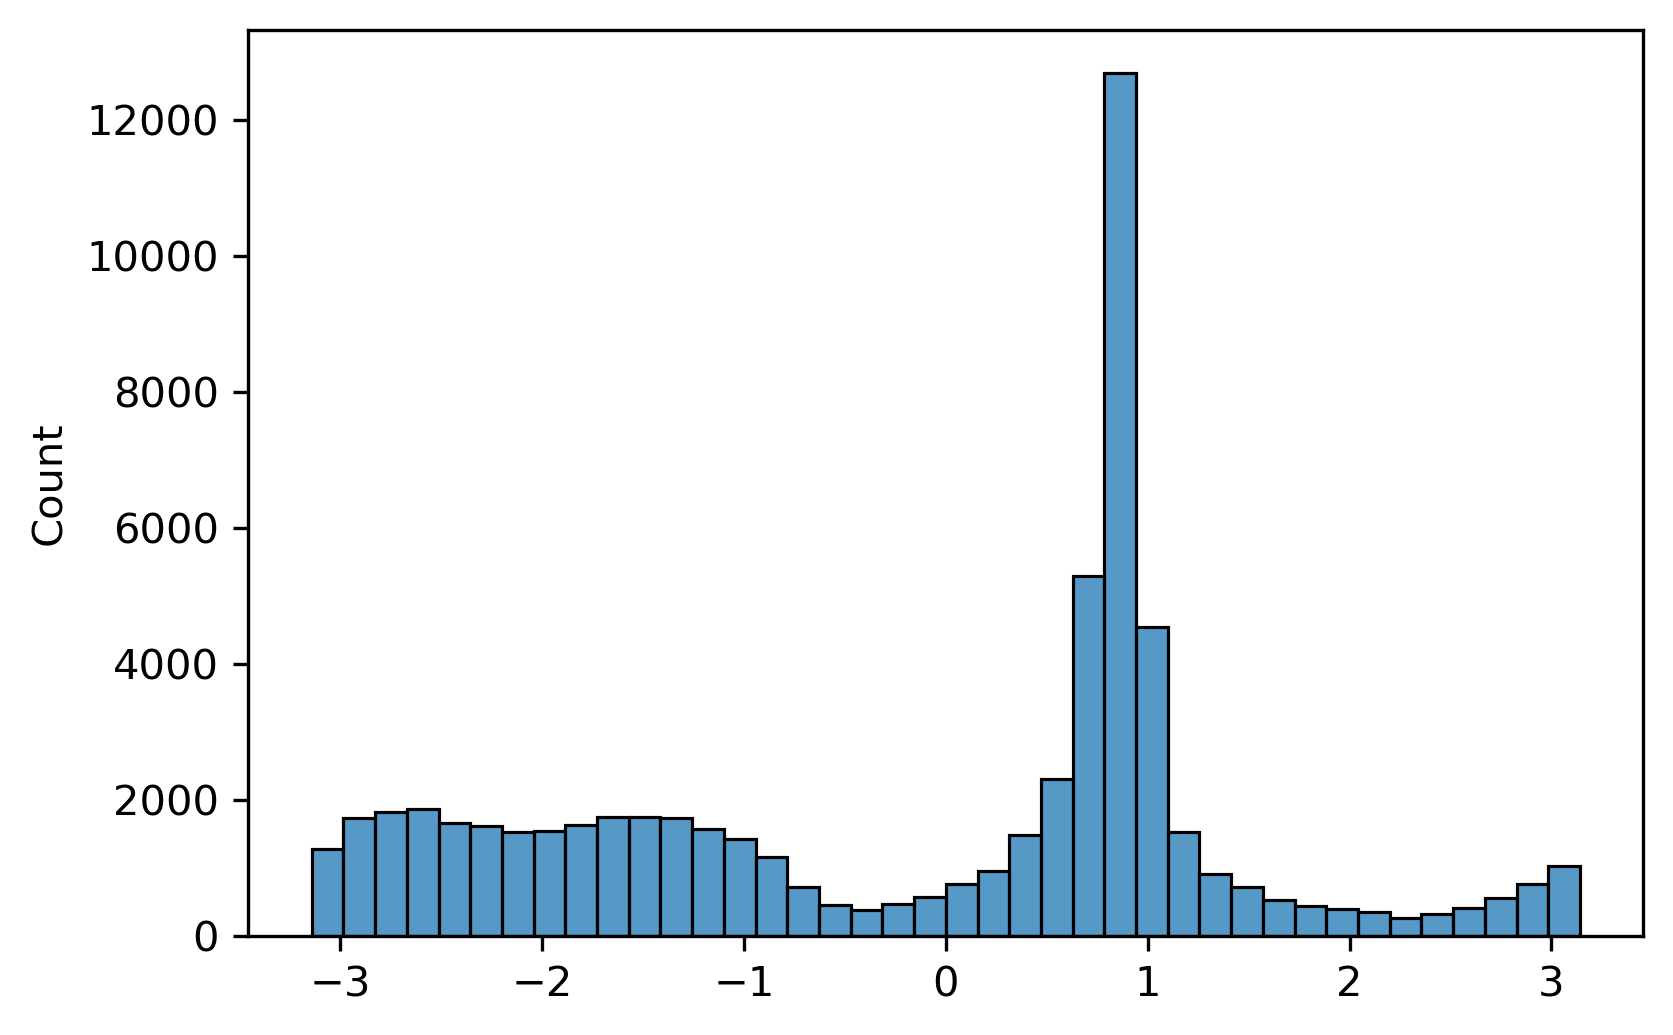

In [6]:
select_by_attn = lambda x: x['angles'][:, ft_idx][x['attn_mask'] != 0]

# Select the un-noised angles
train_values = [select_by_attn(train_dset.dset[i]) for i in range(len(train_dset))]
train_values_flat = np.concatenate(train_values)

fig, ax = plt.subplots(dpi=300)
sns.histplot(train_values_flat, bins=40, ax=ax)
fig.show()

/anaconda/envs/protdiff/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/anaconda/envs/protdiff/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


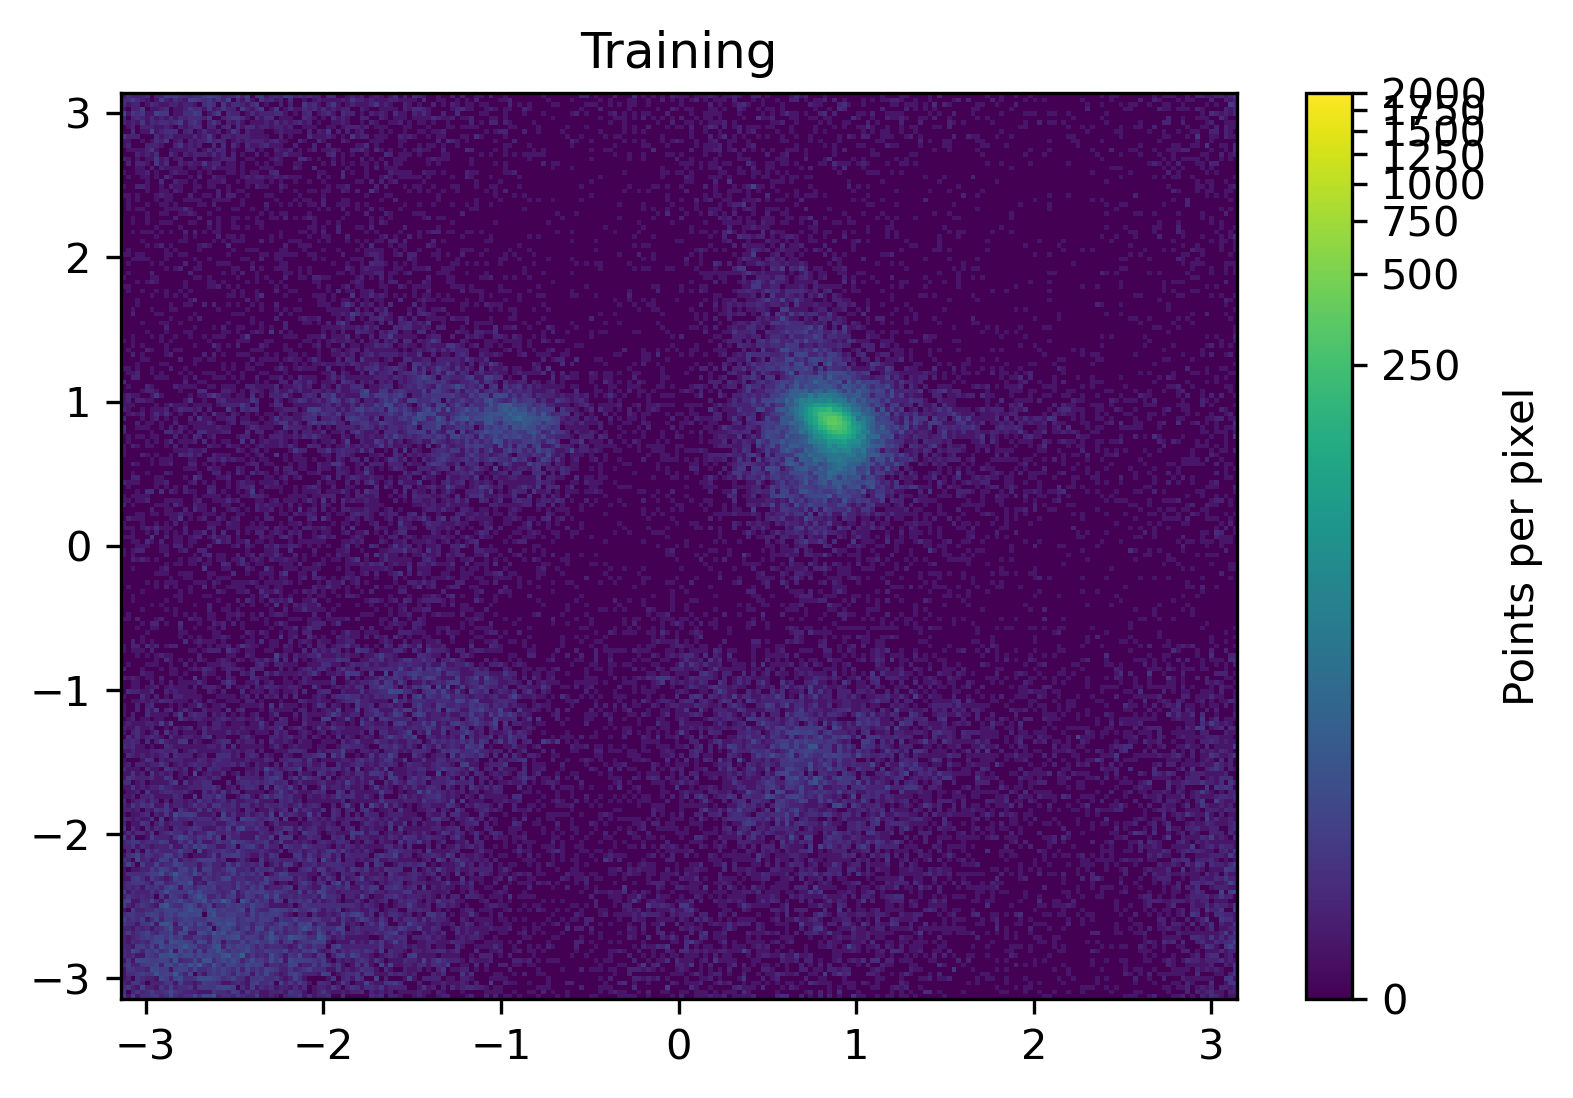

In [34]:
importlib.reload(plotting)

plotting.plot_consecutive_heatmap(train_values, title='Training').show()

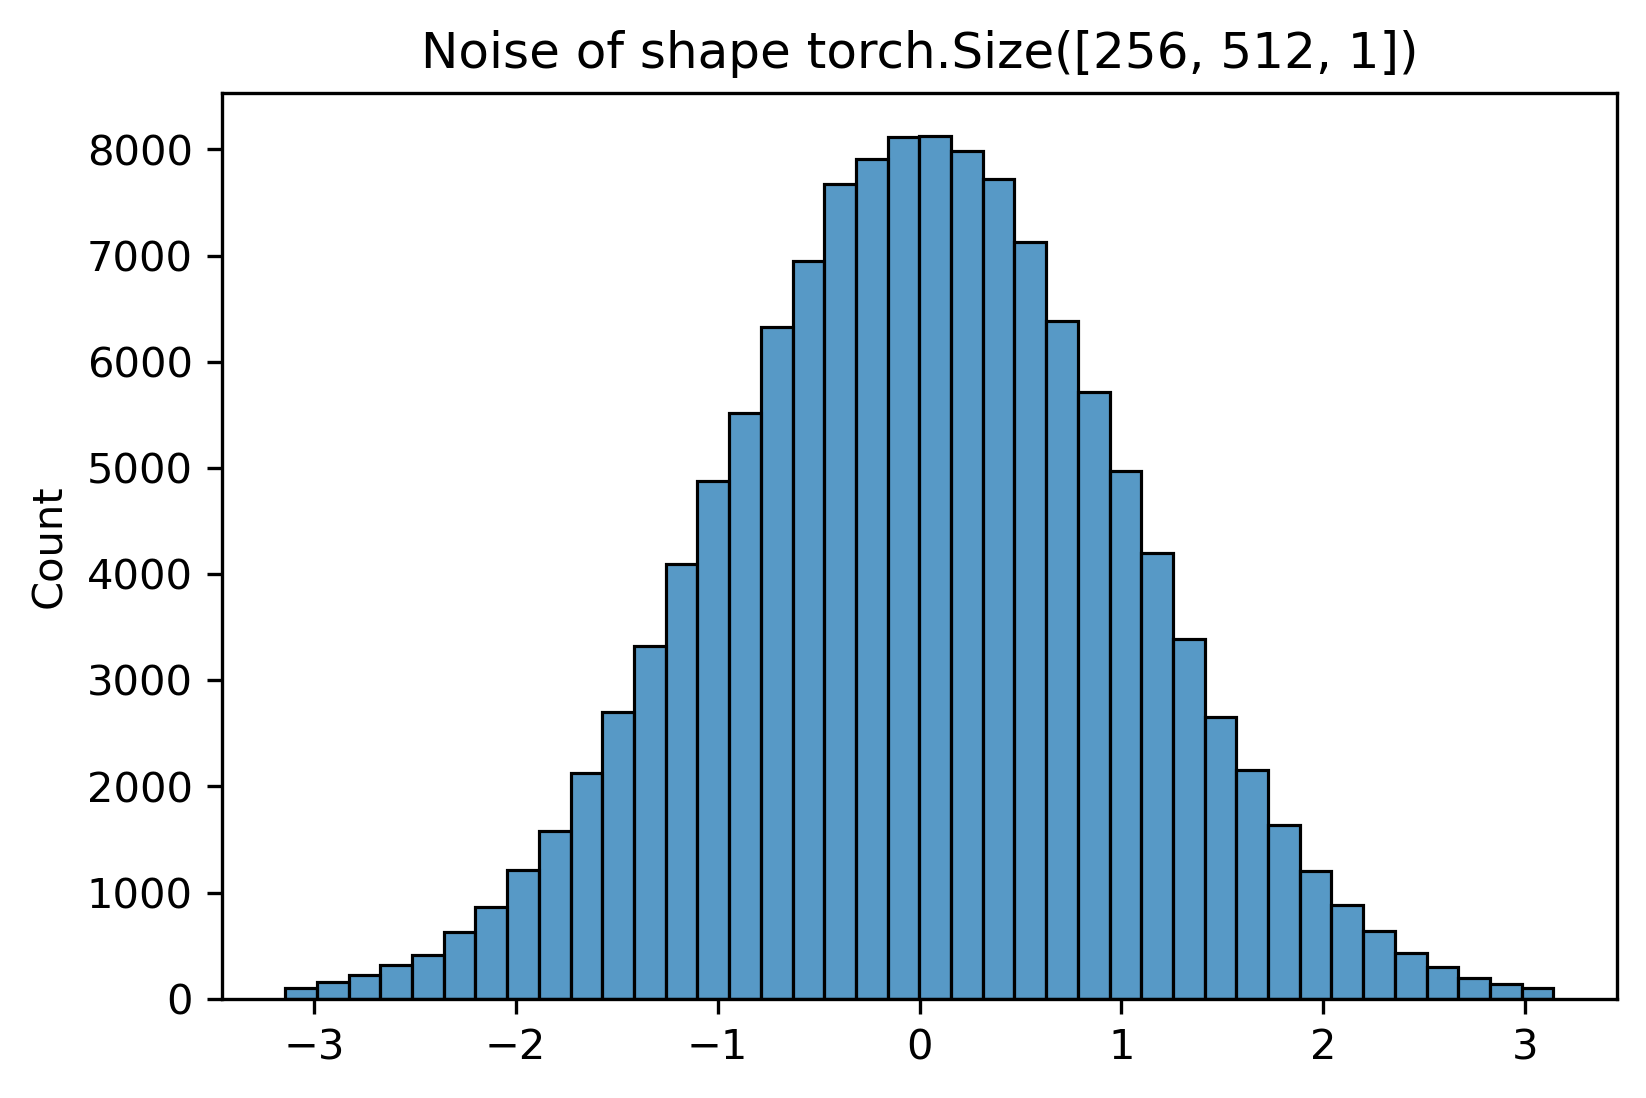

In [7]:
importlib.reload(sampling)

n = 256

# Selects the noise for angle
noise = train_dset.sample_noise(torch.zeros((n, 512, 4), dtype=torch.float32))[:, :, 1].unsqueeze(-1)
assert torch.all(noise >= -torch.pi) and torch.all(noise <= torch.pi)
fig, ax = plt.subplots(dpi=300)
sns.histplot(noise.numpy().flatten(), bins=40, ax=ax)
ax.set(title=f"Noise of shape {noise.shape}")
fig.show()

In [8]:
importlib.reload(modelling)
model = modelling.BertForDiffusion.from_dir(MODEL_DIR, n_inputs=1).to(torch.device("cuda"))

INFO:root:Found 1 checkpoints
INFO:root:Loading weights from /home/t-kevinwu/projects/protein_diffusion/models_overfitted/overfit_omega_mlp_decoder/logs/lightning_logs/version_0/checkpoints/epoch=867-step=2604.ckpt
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpurjbo235
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpurjbo235/_remote_module_non_scriptable.py
INFO:root:Using loss: [<function smooth_l1_loss at 0x7f78acea7430>, functools.partial(<function radian_smooth_l1_loss at 0x7f7887722040>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f7887722040>, beta=0.3141592653589793), functools.partial(<function radian_smooth_l1_loss at 0x7f7887722040>, beta=0.3141592653589793)]
INFO:root:Using time embedding: GaussianFourierProjection()


In [9]:
importlib.reload(sampling)

lengths = [train_dset.dset.sample_length() for _ in range(n)]

sampled = sampling.p_sample_loop(
    model=model,
    lengths=lengths,
    noise=torch.clone(noise),
    timesteps=training_args['timesteps'],
    betas=alpha_beta_values['betas'],
    is_angle=True,
)
sampled.shape

INFO:root:Starting from noise torch.Size([256, 512, 1]) with modulo None and range tensor([-3.1414], device='cuda:0') - tensor([3.1393], device='cuda:0') using cuda:0


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([250, 256, 512, 1])

In [10]:
final_sampled = [sampled[-1, i, :l, :] for i, l in enumerate(lengths)]
final_sampled[0].shape

torch.Size([153, 1])

In [11]:
final_sampled_flat = torch.cat(final_sampled, dim=0).squeeze()
final_sampled_flat.shape

torch.Size([50262])

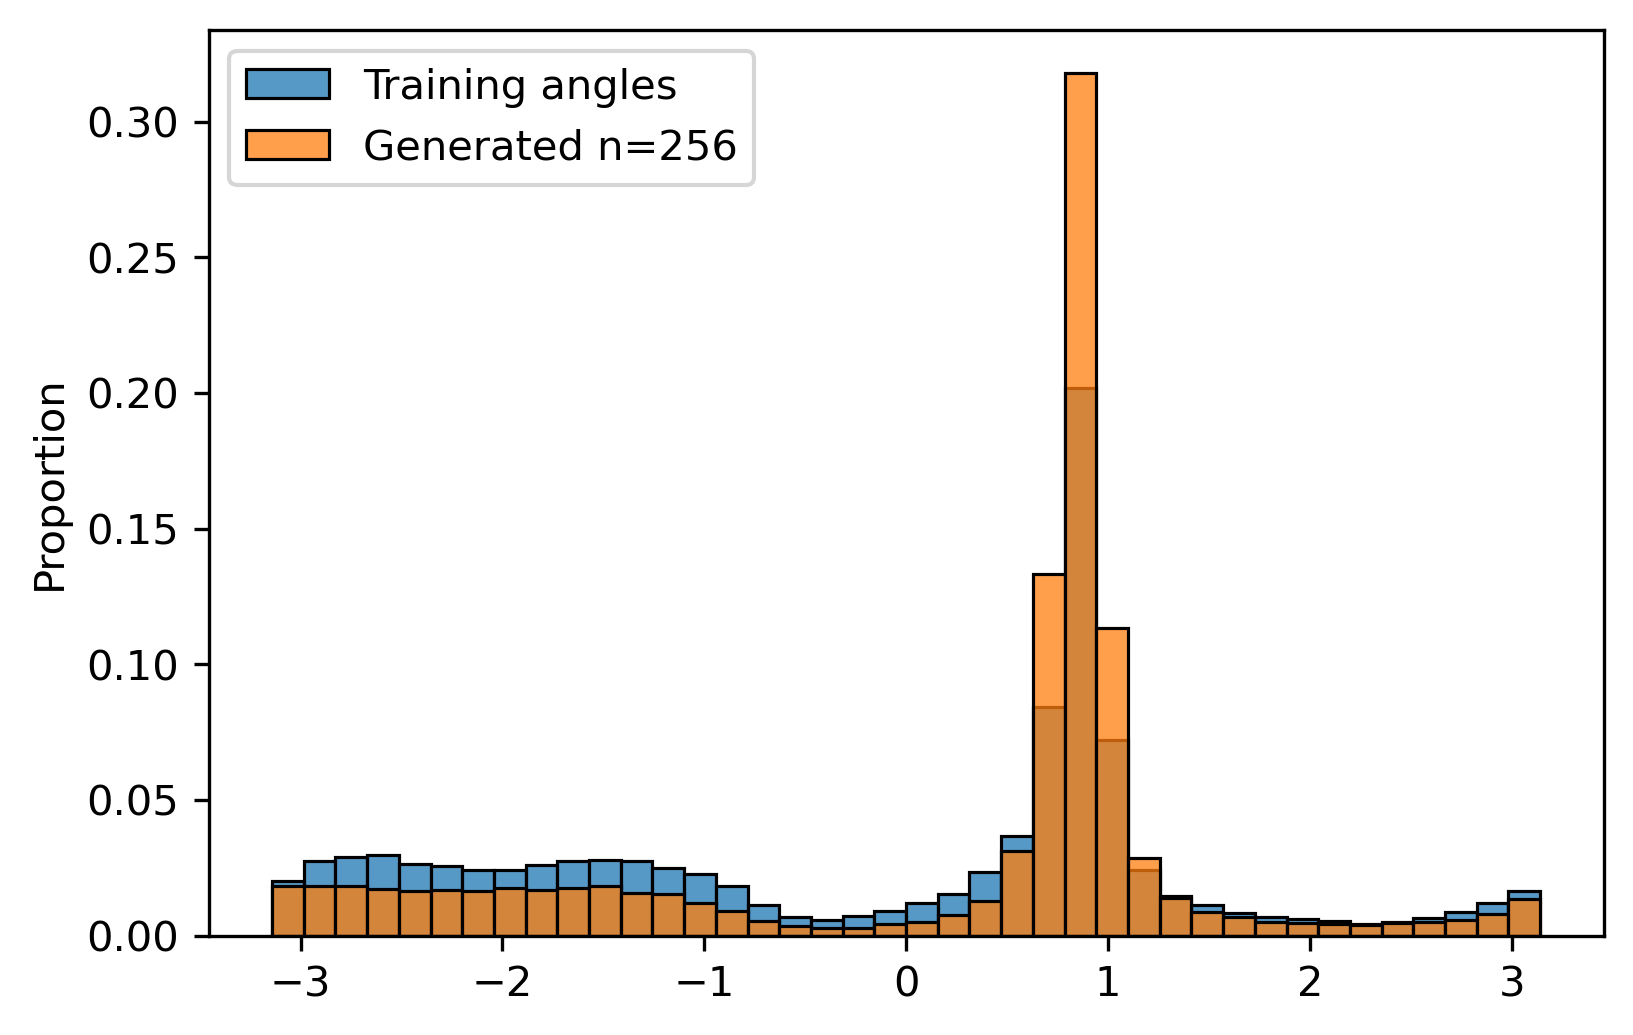

In [12]:
fig, ax = plt.subplots(dpi=300)
sns.histplot(train_values_flat, bins=40, label="Training angles", stat='proportion', ax=ax, color='tab:blue')
sns.histplot(final_sampled_flat.numpy().flatten(), bins=40, label=f"Generated n={n}", stat='proportion', ax=ax, color="tab:orange")
ax.legend()
fig.show()

/anaconda/envs/protdiff/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/anaconda/envs/protdiff/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


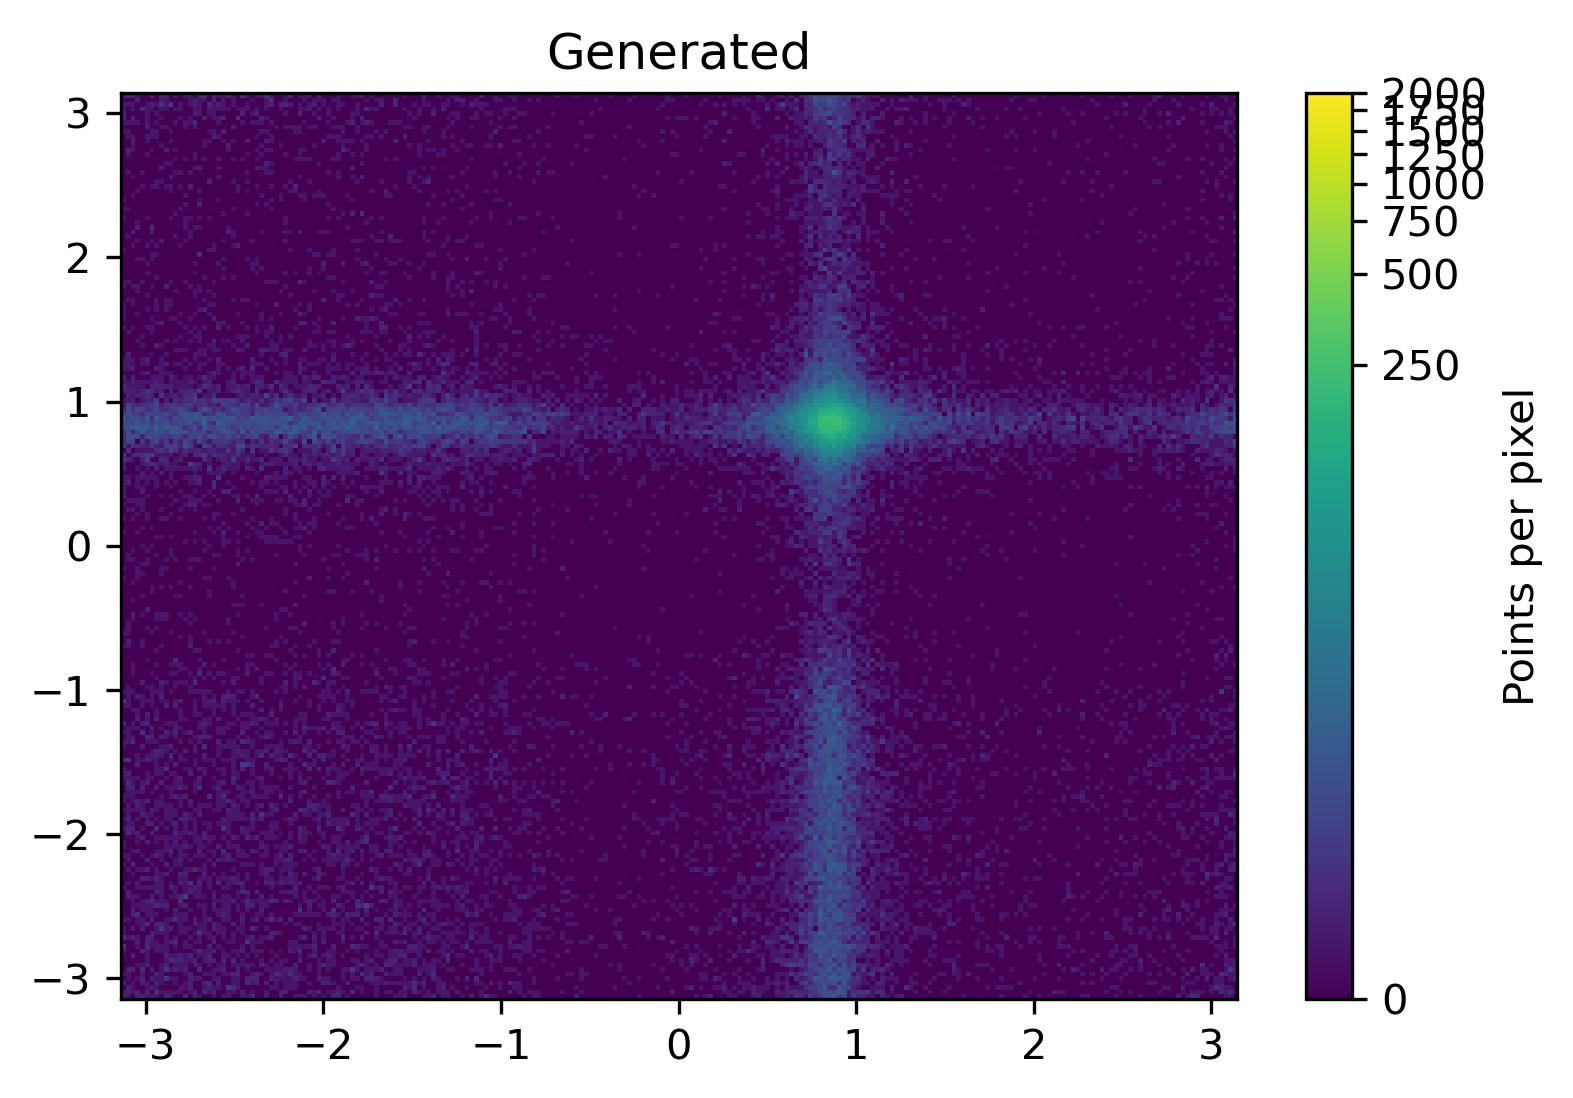

In [33]:
importlib.reload(plotting)

plotting.plot_consecutive_heatmap(final_sampled, title='Generated').show()